# [Multi-class classification with focal loss for imbalanced datasets](https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/)
## focal loss model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

In [2]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [3]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [4]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [5]:
from sklearn.model_selection  import train_test_split
X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
y = keras.utils.to_categorical(y, num_classes=2)
X = feature_normalize(X.as_matrix())
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.5, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

In [17]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

model = Sequential()

from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

In [18]:
def focal_loss(gamma=2., alpha=0.25):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        alphas = tf.constant([1 - alpha, alpha], dtype=tf.float32)
        y_true_bool = tf.cast(y_true, tf.bool)
        focal_loss = -alphas * tf.pow(1. - y_pred, gamma) * tf.log(y_pred + epsilon) * y_true
        reduced_fl = tf.reduce_max(focal_loss, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

model.compile(loss=focal_loss(gamma=2.5, alpha=0.4),
              optimizer='nadam',
              metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train, y_train, epochs=3, batch_size=1000)

Epoch 1/3
3181310/3181310 [==============================] - 5s 1us/step - loss: 9.0289e-04 - acc: 0.9988
Epoch 2/3
3181310/3181310 [==============================] - 5s 1us/step - loss: 3.9488e-04 - acc: 0.9993
Epoch 3/3
3181310/3181310 [==============================] - 5s 1us/step - loss: 3.5745e-04 - acc: 0.9993


In [21]:
eval_loss, eval_accuracy = model.evaluate(X_val, y_val, batch_size=1000)
print("Evaluation loss:", eval_loss)
print("Evaluation accuracy:", eval_accuracy)

1590655/1590655 [==============================] - 1s 1us/step
Evaluation loss: 0.00031899326107282677
Evaluation accuracy: 0.9993807648207685


In [22]:
y_val_labels = np.argmax(y_val, axis=1)
y_pred_val = model.predict(X_val, batch_size=1000)

Threshold: 0.09358303397893906


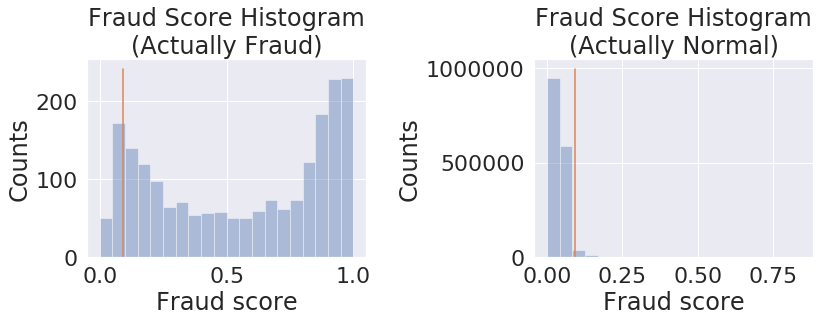

In [23]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

fraud_scores_val = y_pred_val[y_val_labels == 1][:, 1]
normal_scores_val = y_pred_val[y_val_labels == 0][:, 1]
desired_pct_fraud_detected = 90
threshold = np.percentile(fraud_scores_val, 100 - desired_pct_fraud_detected)
# threshold = np.percentile(normal_scores_val, 99.5)
print("Threshold:", threshold)

plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.distplot(fraud_scores_val, bins=20, kde=False);
ylim = plt.ylim()
plt.plot(2 * [threshold], ylim)
plt.xlabel("Fraud score")
plt.ylabel("Counts")
plt.title("Fraud Score Histogram\n(Actually Fraud)")

plt.subplot(122)
sns.distplot(normal_scores_val, bins=20, kde=False);
ylim = plt.ylim()
plt.plot(2 * [threshold], ylim)
plt.xlabel("Fraud score")
plt.ylabel("Counts")
plt.title("Fraud Score Histogram\n(Actually Normal)")

plt.tight_layout()
plt.show()

### Predict normal vs. fraud on test set data
Now, let's analyze our model's performance on the test set data. We'll look at confusion matrix plots and calculate the F1 score.

In [24]:
# use trained model to predict normal vs. fraud on the test set
y_pred_test = model.predict(X_test, batch_size=1000)
np.set_printoptions(precision=3, suppress=True)
print(y_pred_test)

[[0.957 0.043]
 [1.    0.   ]
 [0.994 0.006]
 ...
 [0.948 0.052]
 [0.888 0.112]
 [0.93  0.07 ]]


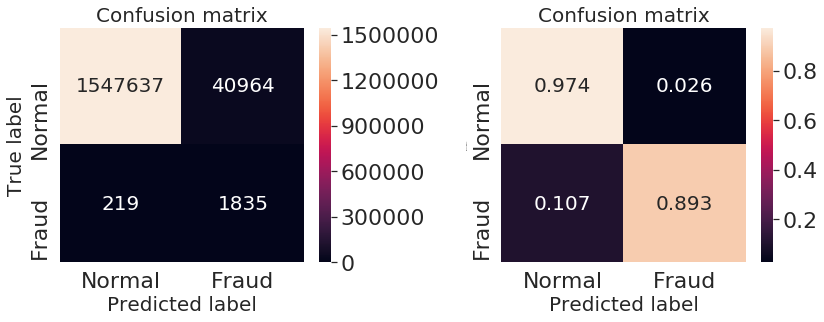

In [25]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

# convert predictions to labels
y_test_class = y_test[:, 1] > threshold
y_pred_class = y_pred_test[:, 1] > threshold
# make confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_class, y_pred_class)
# normalize confusion matrix 
n_truth = np.sum(confusion_matrix, axis=1, keepdims=True)
confusion_matrix_normalized = confusion_matrix / n_truth

# plot raw confusion matrix
LABELS = ['Normal','Fraud'] 
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)

# plot normalized confusion matrix
plt.subplot(122)
sns.heatmap(confusion_matrix_normalized, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".3f", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=2)
plt.xlabel('Predicted label', fontsize=20)
plt.tight_layout()
plt.show()

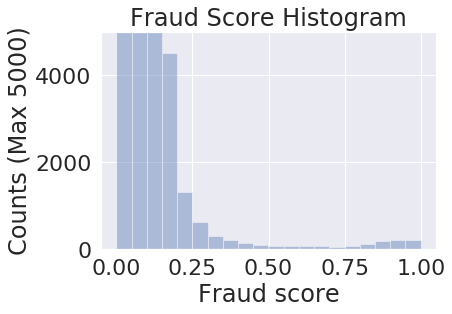

In [26]:
plt.figure()
sns.distplot(y_pred_test[:, 1], bins=20, kde=False);
plt.ylim([0, 5000])
plt.xlabel("Fraud score")
plt.ylabel("Counts (Max 5000)")
plt.title("Fraud Score Histogram")
plt.show()

In [27]:
y_pred_test_class = y_pred_test[:, 1] > threshold
accuracy = np.sum(y_test_class == y_pred_test_class) / len(y_test_class)
f1_score = metrics.f1_score(y_test_class, y_pred_test_class)
print("Test accuracy:", accuracy)
print("F1 score:", f1_score)

values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
print("Total misclassified samples:", error_count)

Test accuracy: 0.9741094077596965
F1 score: 0.0818228435110249
Total misclassified samples: 41183
